Please watch [this lecture online](https://www.youtube.com/watch?v=lURKzwwVjGo) to get a full background of how we solve the heat equation here. 

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
# patch start [https://stackoverflow.com/questions/16488182/removing-axes-margins-in-3d-plot]
from mpl_toolkits.mplot3d.axis3d import Axis
def _get_coord_info_new(self, renderer):
    mins, maxs, cs, deltas, tc, highs = self._get_coord_info_old(renderer)
    correction = deltas * [1.0/4 + 6.0/11,
                           1.0/4 + 6.0/11,
                           1.0/4]
    mins += correction
    maxs -= correction
    return mins, maxs, cs, deltas, tc, highs
if not hasattr(Axis, "_get_coord_info_old"):
    Axis._get_coord_info_old = Axis._get_coord_info  
Axis._get_coord_info = _get_coord_info_new
#patch end
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 18})

## Propagating wave equation

Now let's try the propagating wave equation:

$$
u_t - c u_x = 0
$$

or 

$$
\frac{\partial u}{\partial t} - c \frac{\partial u}{\partial x} = 0
$$


which looks like

$$
{d \hat{u}(\kappa) \over dt} = c {du(x) \over dx} = - i\kappa\, c\, \hat{u}(\kappa)
$$

after Fourier transform. Again we Fourier modes evolving independently of each other. This time it is also exponential but with a complex exponent that shifts the phase. 

In [15]:
c = -2    # Wave speed
L = 2   # Length of domain
N = 1024 # Number of discretization points
Nt = 100
Tfinal = 1

dx = L/N
x = np.arange(-L/2,L/2,dx) # Define x domain

# Define discrete wavenumbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)

# Initial condition
u0 = 1/np.cosh(x/(L/20))
u0hat = np.fft.fft(u0)

# Simulate in Fourier frequency domain
t = np.linspace(0, Tfinal, Nt)

# in fourier domain
def rhsWave(t, uhat, kappa,c):
    d_uhat = -c*(1j)*kappa*uhat
    return d_uhat

sol = solve_ivp(rhsWave, (t[0],t[-1]), u0hat, args=(kappa,c), t_eval=t)
uhat = sol.y
# Inverse FFT to bring back to spatial domain
u = np.zeros_like(uhat)
for k in range(len(t)):
    u[:,k] = np.fft.ifft(uhat[:,k])
    
u = u.real   

Alternatively we can get the solution by simulating in the spatial domain

In [16]:
# Simulate in spatial domain
def rhsWaveSpatial(t,u,kappa,c):
    uhat = np.fft.fft(u)            # use fourier domain to take derivatives
    d_uhat = (1j)*kappa*uhat
    d_u = np.fft.ifft(d_uhat).real  # back to configurations space
    du_dt = -c*d_u
    return du_dt

sol = solve_ivp(rhsWaveSpatial,(t[0],t[-1]), u0, args=(kappa,c), t_eval=t)
us = sol.y

In [17]:
us.shape

(1024, 100)

Or even just get it from the analytic solution. Here you can see clearly of how simple this particular solution is expressed. Each wavenumber $\kappa$ sine wave picks up a $\kappa c \times t$ phase. This coherently shifts the solution left or right determined by the speed, $c$. 

In [18]:
ua = np.zeros_like(us)
for i, ct in enumerate(t):
    uahat = u0hat * np.exp(-(1j) * kappa * c * ct )
    ua[:,i] = np.fft.ifft(uahat).real

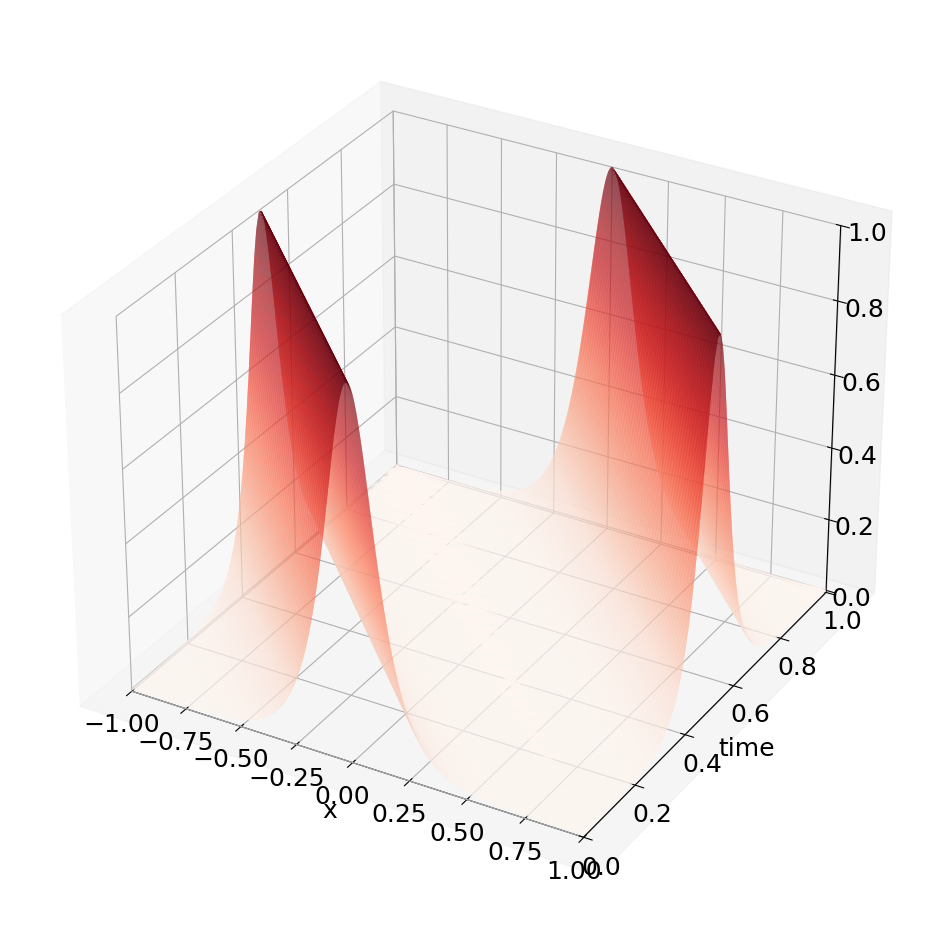

In [19]:
X, Y = np.meshgrid(x, t)
# Plot the surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, us.T,  cmap="Reds", antialiased=True, rstride=1,cstride=1);
ax.set_xlabel("x")
ax.set_ylabel("time");

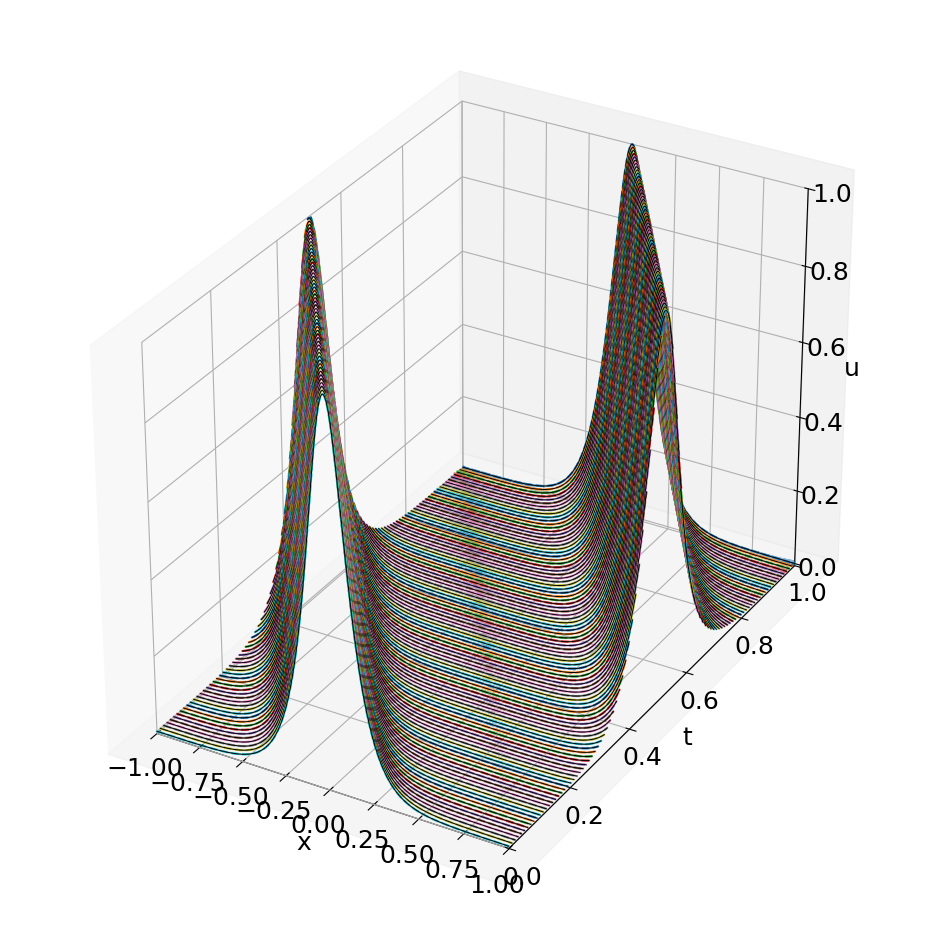

In [20]:
# Waterfall plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for j in range(u.shape[1]-1,-1,-1):
    ys = t[j]*np.ones(u.shape[0])
    color = next(ax._get_lines.prop_cycler)['color'] # cool trick to keep color 
    ax.plot(x,ys,us[:,j],'-',color=color,alpha=0.5)  # our spatial solution
    ax.plot(x,ys,u[:,j],'--',color=color)            # our Fourier solution
    ax.plot(x,ys,ua[:,j],'-',lw=0.7,color='black')            # our Fourier solution
    
plt.xlabel("x")
plt.ylabel("t")

ax.set_zlabel("u")
ax.set_box_aspect([1, 1.5, 1])